## Import libraries

In [1]:
import numpy as np
import pandas as pd
import os
import re
import cv2
from matplotlib import pyplot as plt
import torch

print("Pytorch: " + "GPU" if torch.cuda.is_available() else "CPU")

Pytorch: GPU


In [8]:
model = torch.hub.load("./yolov5", "custom", source='local', path="./modelSaves/best.pt", force_reload=True)

YOLOv5 🚀 v7.0-82-gcec1b9b Python-3.8.15 torch-1.7.1 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11178MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [9]:
test = pd.read_csv("./test.csv")
test

,id,bbox,path
0,4551,"[[0.4410078125, 0.9187517433751744, 0.02207812...",data/000000004551.jpg
1,14873,"[[0.501671875, 0.5315555555555556, 0.0884375, ...",data/000000014873.jpg
2,7355,"[[0.9592578125000001, 0.5132006245120999, 0.08...",data/000000007355.jpg
3,1295,"[[0.6571354166666666, 0.80253125, 0.0498125, 0...",data/000000001295.jpg
4,11099,"[[0.594375, 0.15239583333333334, 0.1765625, 0....",data/000000011099.jpg
5,10545,"[[0.3075, 0.4639791666666666, 0.01696874999999...",data/000000010545.jpg
6,2560,"[[0.3376056338028169, 0.6380208333333333, 0.27...",data/000000002560.jpg
7,6780,"[[0.43653906249999996, 0.35525533890436395, 0....",data/000000006780.jpg
8,19399,"[[0.5039453125, 0.34306264501160094, 0.2542343...",data/000000019399.jpg
9,3532,"[[0.40512499999999996, 0.40506635441061667, 0....",data/000000003532.jpg


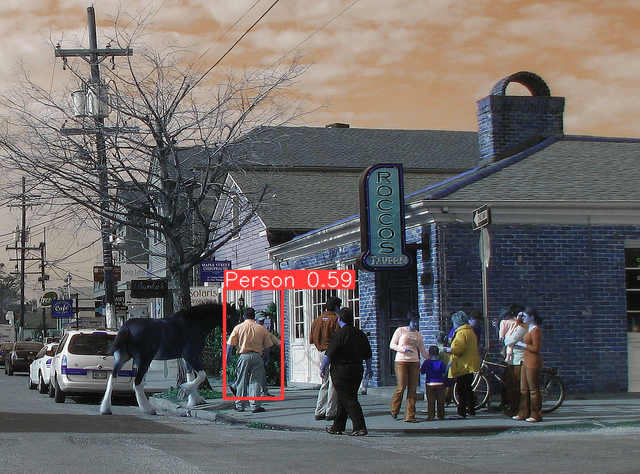

In [19]:
res = model(cv2.imread(test.iloc[22]["path"]))
res.show()

In [13]:
res = pd.DataFrame(res.xywh[0].cpu().numpy(), columns=["x", "y", "w", "h", "confidence", "label"])

In [14]:
print(res.sort_values(by=["confidence"], ascending=False))

            x           y          w           h  confidence  label
0  251.754028  343.521973  55.643906  106.222717    0.741594    0.0


### handle results configuration

In [15]:
res["x"] = res.apply(lambda x:x["x"]+(x["w"]/2), axis=1)
res["y"] = res.apply(lambda x:x["y"]+(x["h"]/2), axis=1)
min_w = res["w"].min()
res["w"] = res.apply(lambda x:(x["w"]/min_w)**2, axis=1)

res = res[res["confidence"]>=0.15][["x", "y", "w"]]
print(res)

            x           y    w
0  279.575981  396.633331  1.0


## Implement clustering

In [16]:
RAND_SEED = 3362
from sklearn.cluster import KMeans

In [17]:
kmeans = KMeans(
    n_clusters = 3, 
    init = 'random',
    n_init = 10,
)

In [18]:
arr = res.to_numpy()
kmeans.fit(arr)

ValueError: n_samples=1 should be >= n_clusters=3.

In [ ]:
preds = kmeans.predict(arr)

## Visualize Clustering result

In [ ]:
# Visualizing predictions with Seaborn pairplot
import matplotlib.pyplot as plt
%matplotlib inline

colors_ = ["green", "blue", "red", "yellow", "purple"]
plt.scatter(arr[:,0], arr[:,1], c=[colors_[i] for i in preds.tolist()])

plt.show()

## Determine cluster density

In [ ]:
tmp = (pd.DataFrame(((res[["x", "y", "w"]].groupby(by=preds).max() - res[["x", "y", "w"]].groupby(by=preds).min()).apply(lambda x: x.x * x.y * x.w, axis=1)), columns=["w"])).rename(columns={"w":"area"})
density = ((pd.DataFrame(res[["w"]].groupby(by=preds).size(), columns=["area"])/tmp)/(res[["w"]].groupby(by=preds).mean()).rename(columns={'w':"area"})).rename(columns={"area":"density"})
density.replace([np.inf, -np.inf], 0, inplace=True)

Create Label to identify if area is crowded
    Threshold to determine if area is crowded

In [ ]:
crowded = density.copy()
crowded["label"] = density.apply(lambda x: x>5.910477e-07)
crowded